In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import sys
import os
# Add the directory to sys.path
datasets_dir = '/dtu/blackhole/16/155094/Video_classification'
sys.path.append(datasets_dir)
from datasets import FrameImageDataset, FrameVideoDataset

In [12]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# |||| MODEL WITH LARGE EPOCHS ||||

In [15]:
batch_size = 64

In [30]:
batch_size = 64

# Dataset directories
root_dir = '/dtu/blackhole/16/155094/ufc101'

# Initialize datasets
train_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Initialize the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = len(train_dataset.df['label'].unique())
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes) # Vi laver et fully connected lag med 10 kategorier 
model._fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with probability 0.5
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [ ]:

model = 

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics storage
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training and Validation Loop
epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Loaded pretrained weights for efficientnet-b0
Epoch [1/10]
Train Loss: 1.7971, Train Accuracy: 56.90%
Val Loss: 1.2593, Val Accuracy: 67.33%
Epoch [2/10]
Train Loss: 0.6004, Train Accuracy: 91.06%
Val Loss: 0.3778, Val Accuracy: 90.42%
Epoch [3/10]
Train Loss: 0.1270, Train Accuracy: 98.82%
Val Loss: 0.2258, Val Accuracy: 93.50%
Epoch [4/10]
Train Loss: 0.0465, Train Accuracy: 99.52%
Val Loss: 0.2240, Val Accuracy: 94.17%
Epoch [5/10]
Train Loss: 0.0323, Train Accuracy: 99.70%
Val Loss: 0.2339, Val Accuracy: 93.58%
Epoch [6/10]
Train Loss: 0.0198, Train Accuracy: 99.80%
Val Loss: 0.2215, Val Accuracy: 94.50%
Epoch [7/10]
Train Loss: 0.0138, Train Accuracy: 99.86%
Val Loss: 0.2315, Val Accuracy: 93.67%
Epoch [8/10]
Train Loss: 0.0098, Train Accuracy: 99.86%
Val Loss: 0.2347, Val Accuracy: 94.08%
Epoch [9/10]
Train Loss: 0.0110, Train Accuracy: 99.96%
Val Loss: 0.2275, Val Accuracy: 94.08%
Epoch [10/10]
Train Loss: 0.0108, Train Accuracy: 99.90%
Val Loss: 0.2471, Val Accuracy: 94.25%


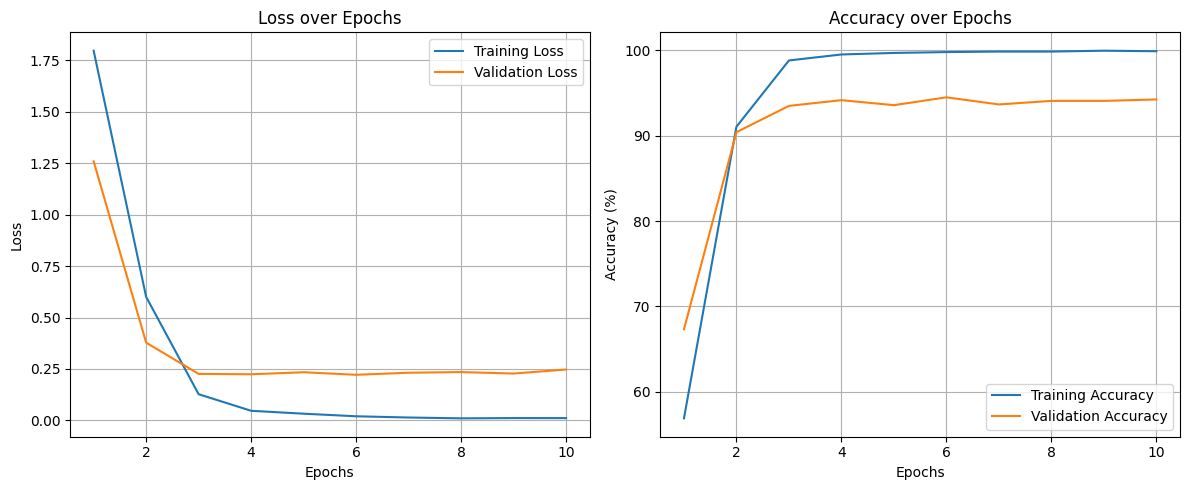

In [33]:
# Plotting Loss over Epochs
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ||||| MINI EPOCHS |||||

In [20]:
batch_size = 16

# Dataset directories
root_dir = '/dtu/blackhole/16/155094/ufc101'

# Initialize datasets
train_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = len(train_dataset.df['label'].unique())
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes) # Vi laver et fully connected lag med 10 kategorier 
model._fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with probability 0.5
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



Loaded pretrained weights for efficientnet-b0


In [21]:
# Metrics storage
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Hyperparameters
epochs = 50  # Number of smaller epochs
mini_epoch_batches = len(train_loader) // 10  # Process 10% of the dataset per mini-epoch
learning_rate = 1e-4  # Adjust if needed

# Adjust optimizer for finer steps
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and Validation Loop
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = 0

    # Limit the number of batches per epoch
    for i, (images, labels) in enumerate(train_loader):
        if i >= mini_epoch_batches:  # Stop after mini_epoch_batches batches
            break

        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch_count += 1

    train_loss = running_loss / batch_count
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch [1/50]
Train Loss: 2.2758, Train Accuracy: 16.33%
Val Loss: 2.2143, Val Accuracy: 20.42%
Epoch [2/50]
Train Loss: 2.1489, Train Accuracy: 27.82%
Val Loss: 2.0836, Val Accuracy: 34.75%
Epoch [3/50]
Train Loss: 1.9846, Train Accuracy: 41.94%
Val Loss: 1.9162, Val Accuracy: 51.08%
Epoch [4/50]
Train Loss: 1.8296, Train Accuracy: 54.03%
Val Loss: 1.6953, Val Accuracy: 59.00%
Epoch [5/50]
Train Loss: 1.5772, Train Accuracy: 68.55%
Val Loss: 1.4323, Val Accuracy: 67.17%
Epoch [6/50]
Train Loss: 1.3428, Train Accuracy: 73.59%
Val Loss: 1.1856, Val Accuracy: 70.83%
Epoch [7/50]
Train Loss: 1.1577, Train Accuracy: 76.61%
Val Loss: 1.0009, Val Accuracy: 73.83%
Epoch [8/50]
Train Loss: 0.9718, Train Accuracy: 78.63%
Val Loss: 0.7961, Val Accuracy: 81.42%
Epoch [9/50]
Train Loss: 0.7682, Train Accuracy: 86.69%
Val Loss: 0.6732, Val Accuracy: 83.42%
Epoch [10/50]
Train Loss: 0.6205, Train Accuracy: 86.90%
Val Loss: 0.5784, Val Accuracy: 84.67%
Epoch [11/50]
Train Loss: 0.5120, Train Accuracy:

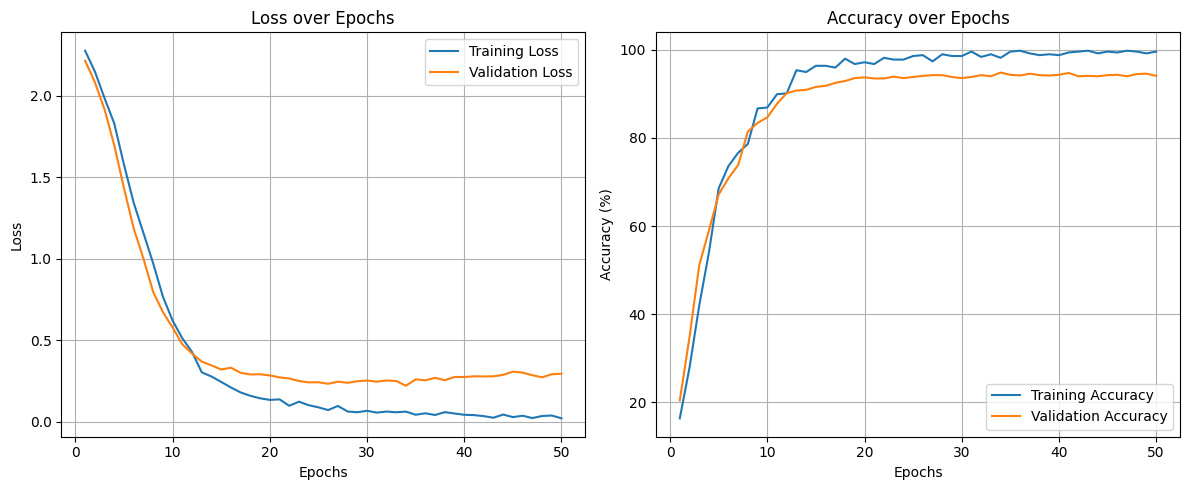

In [22]:
# Plotting Loss over Epochs
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# |||| TEST ON RANDOM IMAGES ||||

In [23]:
train_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)


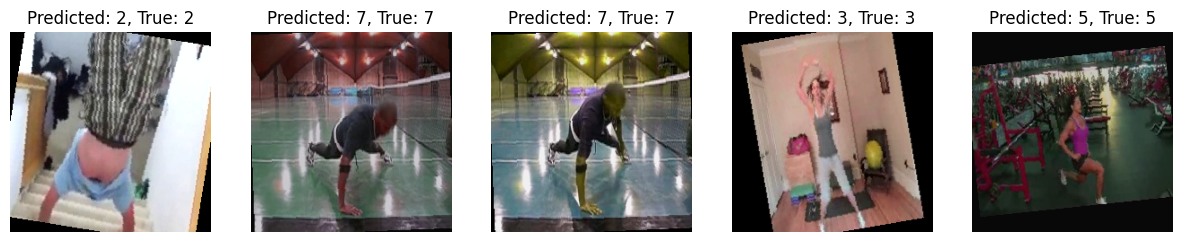

In [34]:
# Visualize Predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)

    # Convert images back to numpy format for plotting
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # [batch, height, width, channels]
    images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    images = np.clip(images, 0, 1)

    # Plot images with predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i].item()}, True: {labels[i].item()}")
        plt.axis('off')

    plt.show()

# Call visualization function
visualize_predictions(model, test_dataset)

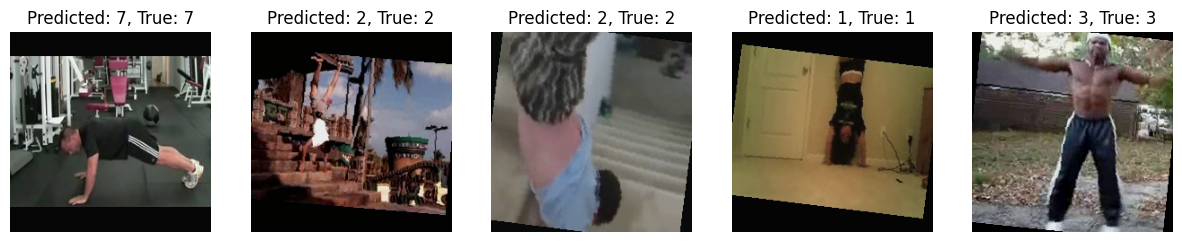

In [35]:
# Visualize Predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)

    # Convert images back to numpy format for plotting
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # [batch, height, width, channels]
    images = images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    images = np.clip(images, 0, 1)

    # Plot images with predicted labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i].item()}, True: {labels[i].item()}")
        plt.axis('off')

    plt.show()

# Call visualization function
visualize_predictions(model, test_dataset)

In [36]:
def test_random_image(image_path):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the same transformations as during training
    transform = T.Compose([
        T.Resize((224, 224)),  # Resize frames for EfficientNet input
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
    ])

    image_tensor = transform(image)  # [C, H, W]

    # Add a batch dimension
    image_tensor = image_tensor.unsqueeze(0)  # [1, C, H, W]

    # Move the image tensor to the appropriate device
    image_tensor = image_tensor.to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Disable gradient computation for inference
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        predicted_label = predicted.item()

    # Map the predicted label index to the class name
    # Assuming you have a mapping from label indices to class names
    # You can create this mapping from your training dataset

    # Extract class names and labels from the dataset
    class_names = train_dataset.df[['label', 'action']].drop_duplicates().sort_values('label')
    label_to_class = dict(zip(class_names['label'], class_names['action']))

    # Get the predicted class name
    predicted_class = label_to_class[predicted_label]

    # Prepare the image for plotting (denormalize)
    image_np = image_tensor.squeeze(0).cpu().numpy()  # [C, H, W]
    image_np = np.transpose(image_np, (1, 2, 0))  # [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    # Plot the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

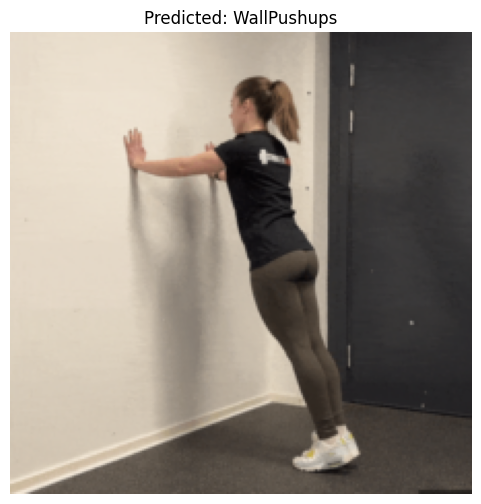

In [37]:
test_random_image("/dtu/blackhole/16/155094/test_image.png")

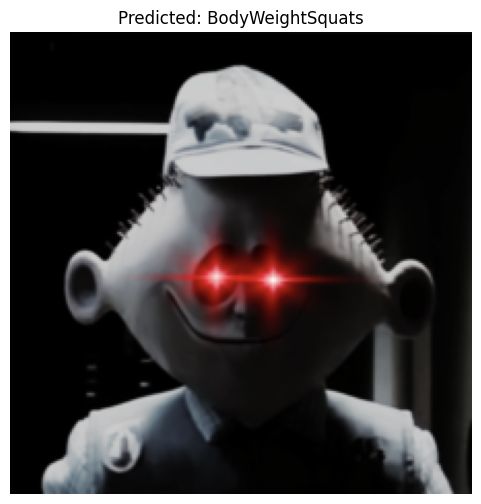

In [38]:
test_random_image("/dtu/blackhole/16/155094/random_test_image2.png")